In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary


In [2]:
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Sat Aug 21 15:28:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.001
MOMENTUM = 0.9
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DOWNLOAD = True

In [4]:
# Transform
transform = transforms.Compose(
                [
                 transforms.Resize(size=(227,227)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5,), (0.5,)),                 
                 transforms.RandomHorizontalFlip(),
                ]
                )

# Data
train_dataset = datasets.CIFAR10(root='/dataset', train=True, download=DOWNLOAD, transform=transform)
valid_dataset = datasets.CIFAR10(root='/dataset', train=False, download=DOWNLOAD, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /dataset/cifar-10-python.tar.gz to /dataset
Files already downloaded and verified


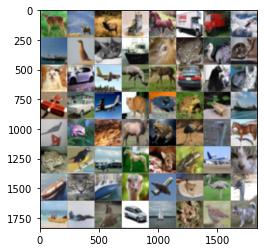


 deer 
 deer 
 deer 
  cat 
horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('\n%5s' % classes[labels[j]] for j in range(5)))

In [16]:

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, padding=2, stride=4)
        self.Conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)
        self.Conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.Conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.Conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.FC1 = nn.Linear(in_features=256*6*6, out_features=4096)
        self.FC2 = nn.Linear(in_features=4096, out_features=1024)
        self.FC3 = nn.Linear(in_features=1024, out_features=num_classes)
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=0.5)
        self.MaxPooling2D = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.ReLU(x)
        x = self.MaxPooling2D(x)
        x = self.Conv2(x)
        x = self.ReLU(x)
        x = self.MaxPooling2D(x)
        x = self.Conv3(x)
        x = self.ReLU(x)
        x = self.Conv4(x)
        x = self.ReLU(x)
        x = self.Conv5(x)
        x = self.ReLU(x)
        x = self.MaxPooling2D(x)
        x = torch.flatten(x,1)
        x = self.FC1(x)
        x = self.Dropout(x)
        x = self.FC2(x)
        x = self.Dropout(x)
        x = self.FC3(x)
       
        return x

In [19]:
model = AlexNet(num_classes)
model = model.to(device)
summary(model, (3,227,227))
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()
# print(model)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

In [20]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # model = model.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            train_acc_per_epoch = 100 * (correct / float(total))
            train_loss_per_epoch = train_loss / total
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch, EPOCH, batch_idx+1, len(train_loader),
               train_acc_per_epoch,
               train_loss_per_epoch))
    return train_acc_per_epoch, train_loss_per_epoch


In [21]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 100 == 0:     
              test_acc_per_epoch = 100 * (correct / float(total))
              test_loss_per_epoch = test_loss / total
              print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
                epoch, EPOCH, batch_idx+1, len(valid_loader),                
                test_acc_per_epoch,
                test_loss_per_epoch))                
            
    return test_acc_per_epoch, test_loss_per_epoch

In [22]:
def training_loop():
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(1,EPOCH):
        # training
        train_acc_, train_loss_ = train(epoch)
        total_train_accuracy.append(train_acc_)
        total_train_loss.append(train_loss_)
        
        valid_acc_, valid_loss_ = test(epoch)        
        total_valid_accuracy.append(valid_acc_)
        total_valid_loss.append(valid_loss_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, EPOCH, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    # print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [23]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop()


Epoch: 1
Train Epoch: 1/10 [iter： 1/782], acc： 12.500000, loss： 0.035935
Train Epoch: 1/10 [iter： 101/782], acc： 10.055693, loss： 0.035979
Train Epoch: 1/10 [iter： 201/782], acc： 10.844216, loss： 0.035973
Train Epoch: 1/10 [iter： 301/782], acc： 10.610465, loss： 0.035971
Train Epoch: 1/10 [iter： 401/782], acc： 11.120636, loss： 0.035967
Train Epoch: 1/10 [iter： 501/782], acc： 11.611153, loss： 0.035960
Train Epoch: 1/10 [iter： 601/782], acc： 12.094426, loss： 0.035947
Train Epoch: 1/10 [iter： 701/782], acc： 12.426444, loss： 0.035911
Valid Epoch: 1/10 [iter： 1/157], acc： 32.812500, loss： 0.033578
Valid Epoch: 1/10 [iter： 101/157], acc： 21.333540, loss： 0.034348
Epoch: 2/10， Train acc： 12.426444， Train loss： 0.035911， Valid acc： 21.333540， Valid loss： 0.034348

Epoch: 2
Train Epoch: 2/10 [iter： 1/782], acc： 21.875000, loss： 0.033568
Train Epoch: 2/10 [iter： 101/782], acc： 23.592203, loss： 0.032998
Train Epoch: 2/10 [iter： 201/782], acc： 24.440299, loss： 0.032491
Train Epoch: 2/10 [iter： 301

In [24]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(1,EPOCH), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(1,EPOCH), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

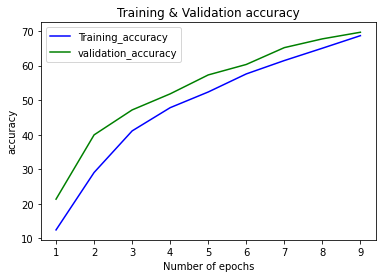

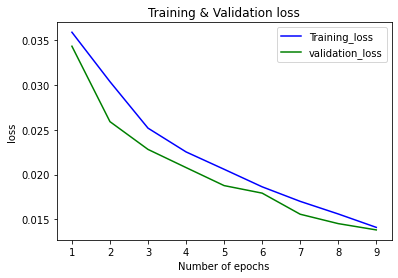

In [25]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')
plot_result(total_train_loss, total_valid_loss, 'loss')